# COGS 108 - Final Project 

# Overview

The goal of this project is to identify if there is a relationship between the number of amenities a recreation center has and their associated Yelp rating. To perform my analysis, I used a dataset that contained Yelp ratings on parks in San Diego and a dataset on the recreation centers in the city. Using a single linear regression model, I found that there is a negative correlation between the number of amenities a recreation center offers and the Yelp rating. That is, as the number of amenities increases, the Yelp rating decreases.

# Name & GitHub

- Name: Tiffany Verner
- GitHub Username: tiffanyverner10

# Research Question

What is the relationship between Yelp ratings and the number of amenities that a San Diego recreation center offers?

## Background and Prior Work

Recreation centers have been offering activities to the City of San Diego since the 1940's. From children to teenagers all the way to senior citizens, these centers provide ways for the community to interact with each other and have fun. Each of San Diego's 57 centers offer a variety of amenities for the community to enjoy, such as racquetball courts for the sports lovers, and stages for the theater lovers (2).

Yelp is a platform used by millions that publishes crowd-sourced reviews of various businesses, restaurants and outdoor activity locations. A search through Yelp yields an list of results ordered by the amount of reviews and how high the ratings are. When searching for things to do or places to eat, many people rely on Yelp to help make their decision. When determining which San Diego recreation center they would like to visit, community members can perform a quick Yelp search that will provide a list of the top 10 recreation centers (1). The ratings and commentary left by fellow members of the community are likely to have some sort of influence on their decision of which center they would like to visit.

References (include links):
- 1) https://www.yelp.com/search?cflt=recreation&find_loc=San+Diego%2C+CA
- 2) https://www.sandiego.gov/park-and-recreation/centers

# Hypothesis


I hypothesize that the recreation centers that have a larger number of amenities will have higher Yelp reviews than the centers that don't have as many amenities. The more that the rec center is able to offer to the community, I imagine the happier the community will be, which in turn will result to higher Yelp reviews.

# Datasets

### Dataset #1
- Dataset Name: yelp_sd_parks.csv
- Link to the dataset: N/A
- Number of observations: 834

This dataset provides the Yelp information of various parks in San Diego. The Yelp information includes the rating, number of reviews, the park's address and more.   
### Dataset #2
- Dataset Name: rec_centers_datasd.geojson
- Link to the dataset: N/A
- Number of observations: 57

This dataset provides information on the recreation centers that are in San Diego. The information includes the center's addres, size in square feet, the community it is in, as well as boolean values representing whether the park has various amenities. Some of these amenities are a kitchen, weight room, tiny tots room, teen center, and more.

In order to complete my analysis on the potential relationship between Yelp ratings and recreation centers, I plan to merge these datasets by the park name. Combining these datasets into one will allow me to create a linear regression model which I will use to examine the effect various predictors have on a Yelp rating.

# Setup

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Statmodels & patsy
import patsy
import statsmodels.api as sm

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

/home/tverner/.local/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Data Cleaning

In [2]:
#load the datasets that will be used for analysis
yelp = pd.read_csv('/home/tverner/individual_fa20/data/yelp_SD_parks.csv')
rec_centers = gpd.read_file('/home/tverner/individual_fa20/data/rec_centers_datasd.geojson')

### Narrowing Down the Data
I began the process of narrowing down the data to only include what I need by merging the two datasets. Doing this first allows me to only have to remove unnecessary columns from one dataset instead of two. I merged the two datasets into one dataframe labeled df based off the park name. Afterwards, I removed all of the unnecessary columns from df.

In [3]:
#merge the dataframes based on the park name
df = pd.merge(yelp, rec_centers, how='inner', left_on='name', right_on='park_name')

In [4]:
#remove unnecessary columns from df
df.drop(columns={'phone', 'id', 'park_name', 'url', 'longitude', 'year_built','latitude', 'is_closed', 
                 'geometry', 'thomas_bro', 'facility_n', 'zip', 'objectid', 'name', 'community', 
                 'address_x', 'address_y', 'serv_dist', 'current_cd', 'comfort_st','fy13_cd'}, inplace=True)

To simplify my dataframe and perform my analysis, I'm going to create a column that is a sum of the ammendities that each recreation center offers. The values in this column are going to be used along with the ratings in my regression model.

In [5]:
df['num_amenities'] = df.iloc[:,8:23].sum(axis=1)

Finally, to ensure that this dataset is easy to understand and read, I'm going to change the titles of the columns. The majority of these columns that I am renaming represent the various amenities that are available at the recreation centers. If these columns have a '1' value in their rows, this means the associated recreation center offers that amenity. For example, as the dataset indicates below, the Linda Vista Rec Center has 1 kitchen and 3 multipurpose rooms. 

In [6]:
df.rename(columns={'review_count':'num reviews'}, inplace=True)
df.rename(columns={'park_name':'park name'}, inplace=True)
df.rename(columns={'teen_ctr':'teen center'}, inplace=True)
df.rename(columns={'stage':'theater stage'}, inplace=True)
df.rename(columns={'dance_rm':'dance room'}, inplace=True)
df.rename(columns={'adult_ctr':'adult center'}, inplace=True)
df.rename(columns={'multp_rm':'multipurpose room'}, inplace=True)
df.rename(columns={'tinytot_rm':'tiny tot room'}, inplace=True)
df.rename(columns={'weight_rm':'weight room'}, inplace=True)
df.rename(columns={'racqb_ct':'racquetball court'}, inplace=True)
df.rename(columns={'rec_bldg':'rec center'}, inplace=True)
df.rename(columns={'kiln_rm':'kiln room'}, inplace=True)
df.rename(columns={'game_rm':'game room'}, inplace=True)
df.rename(columns={'comp_rm':'comp room'}, inplace=True)
df

,rating,num reviews,rec center,sq_ft,adult center,comp room,dance room,game room,gymnasium,kiln,kiln room,kitchen,multipurpose room,racquetball court,theater stage,teen center,tiny tot room,weight room,num_amenities
0,5.0,2105,Municipal Gymnasium,24100,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,5.0,2105,Golden Hills Rec Center,10040,1,0,1,1,1,1,1,1,3,0,0,1,0,0,8
2,5.0,2105,Balboa Park Activity Center,37970,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2
3,4.0,5,Linda Vista Rec Center,13710,0,0,0,0,1,0,0,1,3,0,0,0,0,1,6
4,4.5,18,Allied Gardens Rec Center,9190,0,0,0,1,1,1,1,1,3,0,0,0,0,0,7
5,4.0,21,Gil Johnson Mira Mesa Rec Center,10810,0,0,0,0,1,1,1,1,3,0,0,0,0,0,7
6,3.0,37,North Park Rec Center,11230,1,0,1,1,1,1,1,1,3,0,0,1,1,0,9
7,4.5,7,Canyonside Rec Center,15560,0,0,0,1,1,0,0,0,2,0,0,0,0,0,3
8,5.0,4,Silver Wing Rec Center,2030,0,0,0,0,0,0,0,1,1,0,0,1,0,0,3
9,4.0,4,Mountain View Rec Center,18100,0,1,1,0,1,1,1,1,3,0,1,1,0,1,10


# Data Analysis & Results

First, let's look at the distribution of the ratings of these parks and the number of amenities each recreation center offers. This will help me identify any potential outliers.

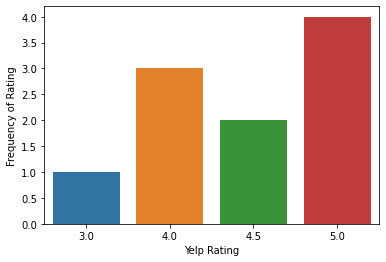

In [7]:
ax = sns.countplot(df['rating']);
ax.set_ylabel('Frequency of Rating')
ax.set_xlabel('Yelp Rating');

Figure #1: There does not seem to be any outliers, and the ratings for the parks are all within 3.0 - 5.0

Let's see the number of amenities the various recreation center offers.

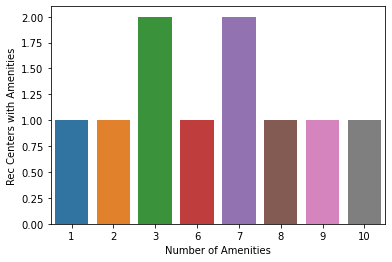

In [8]:
ax = sns.countplot(df['num_amenities']);
ax.set_ylabel('Rec Centers with Amenities')
ax.set_xlabel('Number of Amenities');

Figure #2: Again there aren't any outliers. Interestingly, each recreation center has offers a different number of amenities, except for two.

Now, let's plot the number of amenities versus the Yelp rating.

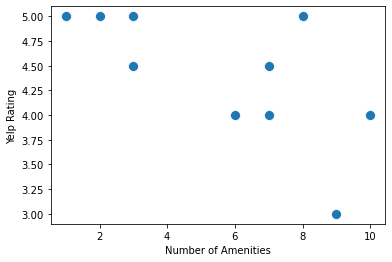

In [9]:
sns.scatterplot(x='num_amenities', y='rating', data=df, s=100)
plt.xlabel('Number of Amenities')
plt.ylabel('Yelp Rating');

Figure #3: It looks like there might be a slight negative correlation suggesting that as the number of amenities increases, the Yelp reviews decrease.

To get a better understanding of the relationship between these two variables, I am going to use a single linear regression model.

In [10]:
#predict ratings from num_amenities
outcome, predictors = patsy.dmatrices('rating ~ num_amenities', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     6.440
Date:                Mon, 14 Dec 2020   Prob (F-statistic):             0.0348
Time:                        17:22:40   Log-Likelihood:                -6.5285
No. Observations:                  10   AIC:                             17.06
Df Residuals:                       8   BIC:                             17.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.1855      0.350     14.797

There are a few things that the model above indicates.

If the number of amenities at the recreation center was 0, then the Yelp rating would be 5.1855. Since Yelp reviews are on a scale of 1.0 - 5.0, this makes me wonder if there were some outliers or unexpected data in my dataset. For every amenity that gets added to a recreation center, there is a -0.14 decrease in the Yelp rating. This contradicts my initial hypothesis that an increase an amenities would have an increase in the Yelp rating.

The p-value associated with the num_amenities value is 0.035. For my analysis, I have decided to have my alpha level be 0.05. This means that since my p-value is 0.035, this value is statistically significant. 

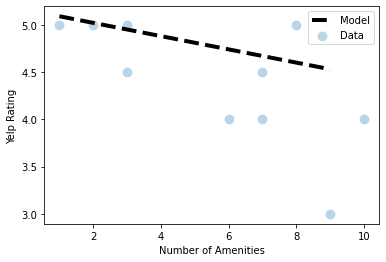

In [11]:
#Plot the orginal data (as before)
sns.scatterplot(x='num_amenities', y='rating', alpha=0.3, data=df, s=100, label='Data')

# Generate and plot the model fit line
xs = np.arange(df['num_amenities'].min(), df['num_amenities'].max())
ys = -0.07 * xs + 5.16
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

plt.xlabel('Number of Amenities')
plt.ylabel('Yelp Rating')
plt.legend();

Figure #4: The graph above illustrates the model I just ran. As we can see from the dotted line, there is a slight decrease in the Yelp rating as the rec center has more amenities. 

To get another look at the data, I decided to add another predictor variable: the size of the park in square feet. I want to note that these size values come from the recreation center dataset, but it was not made explicitly clear whether these values represent the size of the park or the recreation center. For the rest of my analysis, I am going to assume that this variable represents the size of the entire park which includes the recreation center. I decided to include this size predictor in my analysis because a larger sized park and a recreation center can influence a user's Yelp rating, as a larger park implies more space for activities and people.

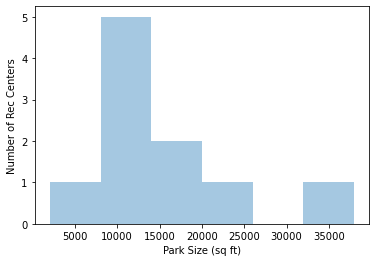

In [12]:
ax = sns.distplot(df['sq_ft'], kde=False)
ax.set_xlabel('Park Size (sq ft)')
ax.set_ylabel('Number of Rec Centers');

Figure #5: The majority of the parks in this dataset are around 10,000 - 15,000 square feet big. There is one larger park that is around 35,000 feet. I ran a test OLS model to determine if this 35,000 value was an outlier that had a significant effect on the results of the model. The results were fairly the same with/without this value, so I decided to leave it in my dataset for the multiple linear regression model that I will perform below. 

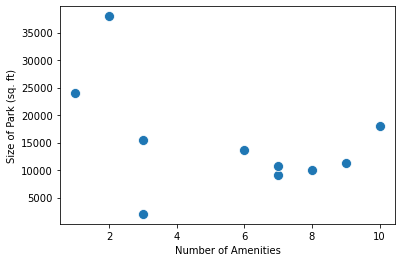

In [13]:
#plot num_amenities vs. sq_ft
sns.scatterplot(x='num_amenities', y='sq_ft', data=df, s=100)
plt.xlabel('Number of Amenities')
plt.ylabel('Size of Park (sq. ft)');

Figure # 6: Above is a scatterplot illustrating the number of amenities of a recreation center and the size of park.
Oddly enough, the two largest parks have the least amount of amenities in their rec centers. To get a better idea of how these predictors effect a Yelp rating, I will use a multiple linear regression model.

In [14]:
#predict ratings from num_amenities and sq_ft
outcome_2, predictors_2 = patsy.dmatrices('rating ~ num_amenities + sq_ft', df)
model_2 = sm.OLS(outcome_2, predictors_2)
results_2 = model_2.fit()

print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     2.840
Date:                Mon, 14 Dec 2020   Prob (F-statistic):              0.125
Time:                        17:22:46   Log-Likelihood:                -6.5108
No. Observations:                  10   AIC:                             19.02
Df Residuals:                       7   BIC:                             19.93
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.2594      0.600      8.765

Holding the sq_ft variable constant, there is a still -0.14 decrease in Yelp ratings for every 1 unit increase in num_amenities. The coefficient of the sq_ft variable is extremely small to the point where it can be removed from my interpretation of this model. Additionally, the p-value of the sq_ft variable is not significant, so it seems like this multiple linear regression model doesn't explain the variance better than the single linear regression model above.

# Ethics & Privacy

The datasets that I used for this analysis were provided for me. Information on the parks and recreation centers of San Diego are public information that can be found on the San Diego government website. The information from the Yelp dataset, which I presume was taken directly from the Yelp website, is also public knowledge and accessible to anyone via Yelp's website. Both of my datasets did not contain information of any human individuals so I did not have to be concerned about anyone's privacy while conducting my analysis. A potential area of concern could have been of privacy of the individuals that are making the Yelp reviews. However, my dataset was more focused on the overall Yelp rating that results from peoples' reviews instead of the reviews themselves, and thus the individual reviews were not part of the dataset.

The use of Yelp information in my analysis means that there is a huge amount of potential bias. Each review that is placed on Yelp is biased in its own way and not representative of a whole population. Many people have positive and negative experiences that may influence a business' Yelp rating but they do not write a review. Since I decided to use Yelp in this project, it is crucial for me to note that the biases that Yelp data propose are unavoidable but also potentially influential on the data. From my understanding, since the biased data is necessary for my analysis, the best way for me to handle this issue is by making it clear that I'm aware of the biases and acknowledging that my results may not be entirely accurate.

# Conclusion & Discussion

In this project I set out to examine if there is a relationship between the number of amenities a recreation center has and the Yelp rating associated with the center. I began this process by merging the Yelp dataset with the recreation center dataset and removing all of the unnecessary data. Once my data was clean and easy to read, I started my analysis by looking at the distributions of the variables of interest and looking to see if there were interesting patterns. From there, I used a single linear regression model to create a line of best fit to help me visualize the correlation between the number of amenities and the Yelp rating. The results of this model contradicted my initial hypothesis and suggested that as the number of amenities of a recreation center increases, the Yelp reviews decrease.
I decided to create a second linear regression model using a second predictor variable: the size of the park in square feet. My goal was to determine what effect the number of amenities combined with the size of the park had on the Yelp rating of the park. The results from the multiple linear regression model I ran indicated that the addition of the size variable did not have a significant effect on the the Yelp rating variable.

There were quite a few limitations to my analysis. First, there were not nearly as many points in my dataset as I would have liked. Having a small amount of data points to work with means that each quality of the data point can have a significant impact on the entire dataset. Additionally, since the dataset was given to me, I feel like I did not have a complete understanding of the values in it. There were some columns where I did not understand what the header meant, even with researching on the San Diego parks and recreation website. Since I did not have a full understanding of the dataset, it is likely that I could have removed some columns that actually would have been useful for my analysis.

The results of this project could potentially be used by the parks and recreation officials of San Diego. One interpretation of these results could be that the more amenities a recreation center has, the more poorly the recreation center is taken care of because the staff is spread more thin. This could explain the lower Yelp reviews, and therefore this can suggest to the San Diego officials that there needs to be more attention placed on the recreation centers with more amenities. 